In [1]:
#All from https://chatgpt.com/c/671bc911-7094-800b-b09e-824ba256034c
#Not checked. Trust nothing.

Optimization Progress: 100%|████████████████████| 50/50 [04:06<00:00,  4.93s/it]


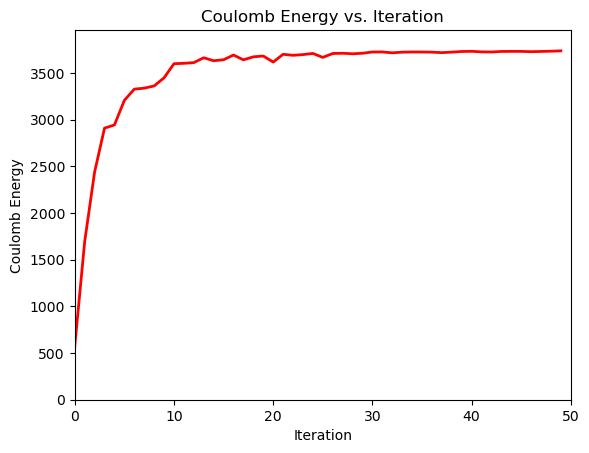

First few optimized points:
[[ 0.49034868  0.23671973  0.46606526  0.37985099 -0.29837156 -0.50410757]
 [-0.01570653  0.60333804  0.70066347  0.28074438 -0.21482834  0.14384014]
 [-0.01060424  0.80158332  0.18833996  0.15661646  0.27968716 -0.46916457]
 [ 0.03072295  0.14863731  0.6870399   0.44358512  0.46597265 -0.30460056]
 [ 0.92915508  0.20173533  0.04899611  0.2883566   0.07733737 -0.07631924]]
Norms of optimized points (should all be close to 1): [1.00056568 1.00042561 1.00049449 1.0008699  1.00069083 1.00049184
 1.0004039  1.00045912 1.00055888 1.00080728 1.00063502 1.00172858
 1.00082586 1.000636   1.00064019 1.00080141 1.00099628 1.00047445
 1.00063727 1.0005563  1.00056864 1.00087312 1.0004771  1.00084614
 1.00063116 1.00035815 1.00042088 1.00051101 1.00057463 1.00033101
 1.00052797 1.00074055 1.00071289 1.00048647 1.00077221 1.00052434
 1.00089785 1.00039849 1.00041253 1.00051234 1.00088262 1.00040491
 1.00033401 1.00058053 1.00079215 1.00048369 1.00039612 1.00043296
 1.000

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

class LivePlot:
    """Class to handle the live-updating plot of the optimization progress."""
    def __init__(self, max_iter):
        self.max_iter = max_iter
        self.iterations = []
        self.energy_values = []

        # Set up the plot
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot([], [], 'r-', lw=2)
        self.ax.set_xlim(0, max_iter)
        self.ax.set_ylim(0, 10)  # Initial limit, will adjust dynamically
        self.ax.set_xlabel('Iteration')
        self.ax.set_ylabel('Coulomb Energy')
        self.ax.set_title('Coulomb Energy vs. Iteration')

    def update(self, iteration, energy):
        """Update the plot with the current iteration and energy."""
        self.iterations.append(iteration)
        self.energy_values.append(energy)

        # Adjust plot limits dynamically
        if energy > self.ax.get_ylim()[1]:
            self.ax.set_ylim(0, energy * 1.1)

        self.line.set_data(self.iterations, self.energy_values)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

def generate_initial_points(num_points):
    """Generate `num_points` uniformly distributed on the 6-sphere (S^6)."""
    points = np.random.normal(size=(num_points, 6))
    points /= np.linalg.norm(points, axis=1)[:, np.newaxis]  # Normalize to S^6
    return points

def coulomb_energy(points):
    """Compute the total Coulomb energy of the points on the 6-sphere."""
    energy = 0.0
    num_points = len(points)
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(points[i] - points[j])
            energy += 1.0 / dist  # Coulomb potential (1/r)
    return energy

def constraint_to_sphere(point):
    """Constraint: Ensure each point remains on the 6-sphere (unit norm)."""
    return np.linalg.norm(point) - 1.0

def optimize_points_with_live_plot(initial_points, max_iter=1000):
    """Optimize points with a progress bar and live energy plot."""
    num_points, dim = initial_points.shape
    flat_points = initial_points.flatten()

    # Set up the progress bar and live plot
    pbar = tqdm(total=max_iter, desc="Optimization Progress", leave=True)
    live_plot = LivePlot(max_iter)

    def callback(x):
        """Callback function to update the progress bar and live plot."""
        current_iter = len(live_plot.iterations)
        energy = coulomb_energy(x.reshape(num_points, dim))
        live_plot.update(current_iter, energy)
        pbar.update(1)

    # Minimize the Coulomb energy with constraints
    result = minimize(
        fun=lambda x: coulomb_energy(x.reshape(num_points, dim)),
        x0=flat_points,
        constraints=[{'type': 'eq', 'fun': lambda x, i=i: constraint_to_sphere(x[i * dim:(i + 1) * dim])} for i in range(num_points)],
        method='SLSQP',
        options={'maxiter': max_iter, 'ftol': 1e-9},
        callback=callback
    )

    pbar.close()  # Close the progress bar when done
    return result.x.reshape(num_points, dim)

# Generate initial points
initial_points = generate_initial_points(100)

# Start live plotting mode
plt.ion()  # Enable interactive mode

# Run optimization with live plot and progress bar
optimized_points = optimize_points_with_live_plot(initial_points, max_iter = 50)

# Disable interactive mode and show the final plot
plt.ioff()
plt.show()

# Verify the optimized points
print("First few optimized points:")
print(optimized_points[:5])

# Verify norms to ensure all points lie on the 6-sphere
norms = np.linalg.norm(optimized_points, axis=1)
print("Norms of optimized points (should all be close to 1):", norms)


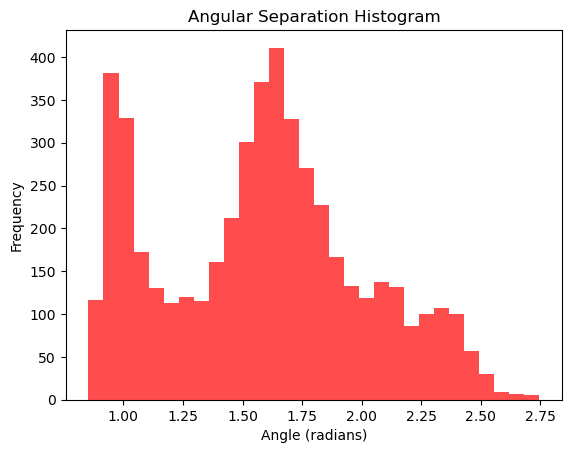

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def compute_angular_separation(points):
    """Compute the angular separation between all pairs of points."""
    num_points = len(points)
    angles = []

    for i in range(num_points):
        for j in range(i + 1, num_points):
            # Compute the cosine of the angle
            cosine_theta = np.dot(points[i], points[j])
            # Convert to angle in radians
            theta = np.arccos(np.clip(cosine_theta, -1.0, 1.0))
            angles.append(theta)

    return np.array(angles)

def plot_angular_separation_histogram(angles):
    """Plot a histogram of angular separations between points."""
    plt.hist(angles, bins=30, alpha=0.7, color='r')
    plt.xlabel('Angle (radians)')
    plt.ylabel('Frequency')
    plt.title('Angular Separation Histogram')
    plt.show()

# Compute and plot angular separations
angles = compute_angular_separation(optimized_points)
plot_angular_separation_histogram(angles)


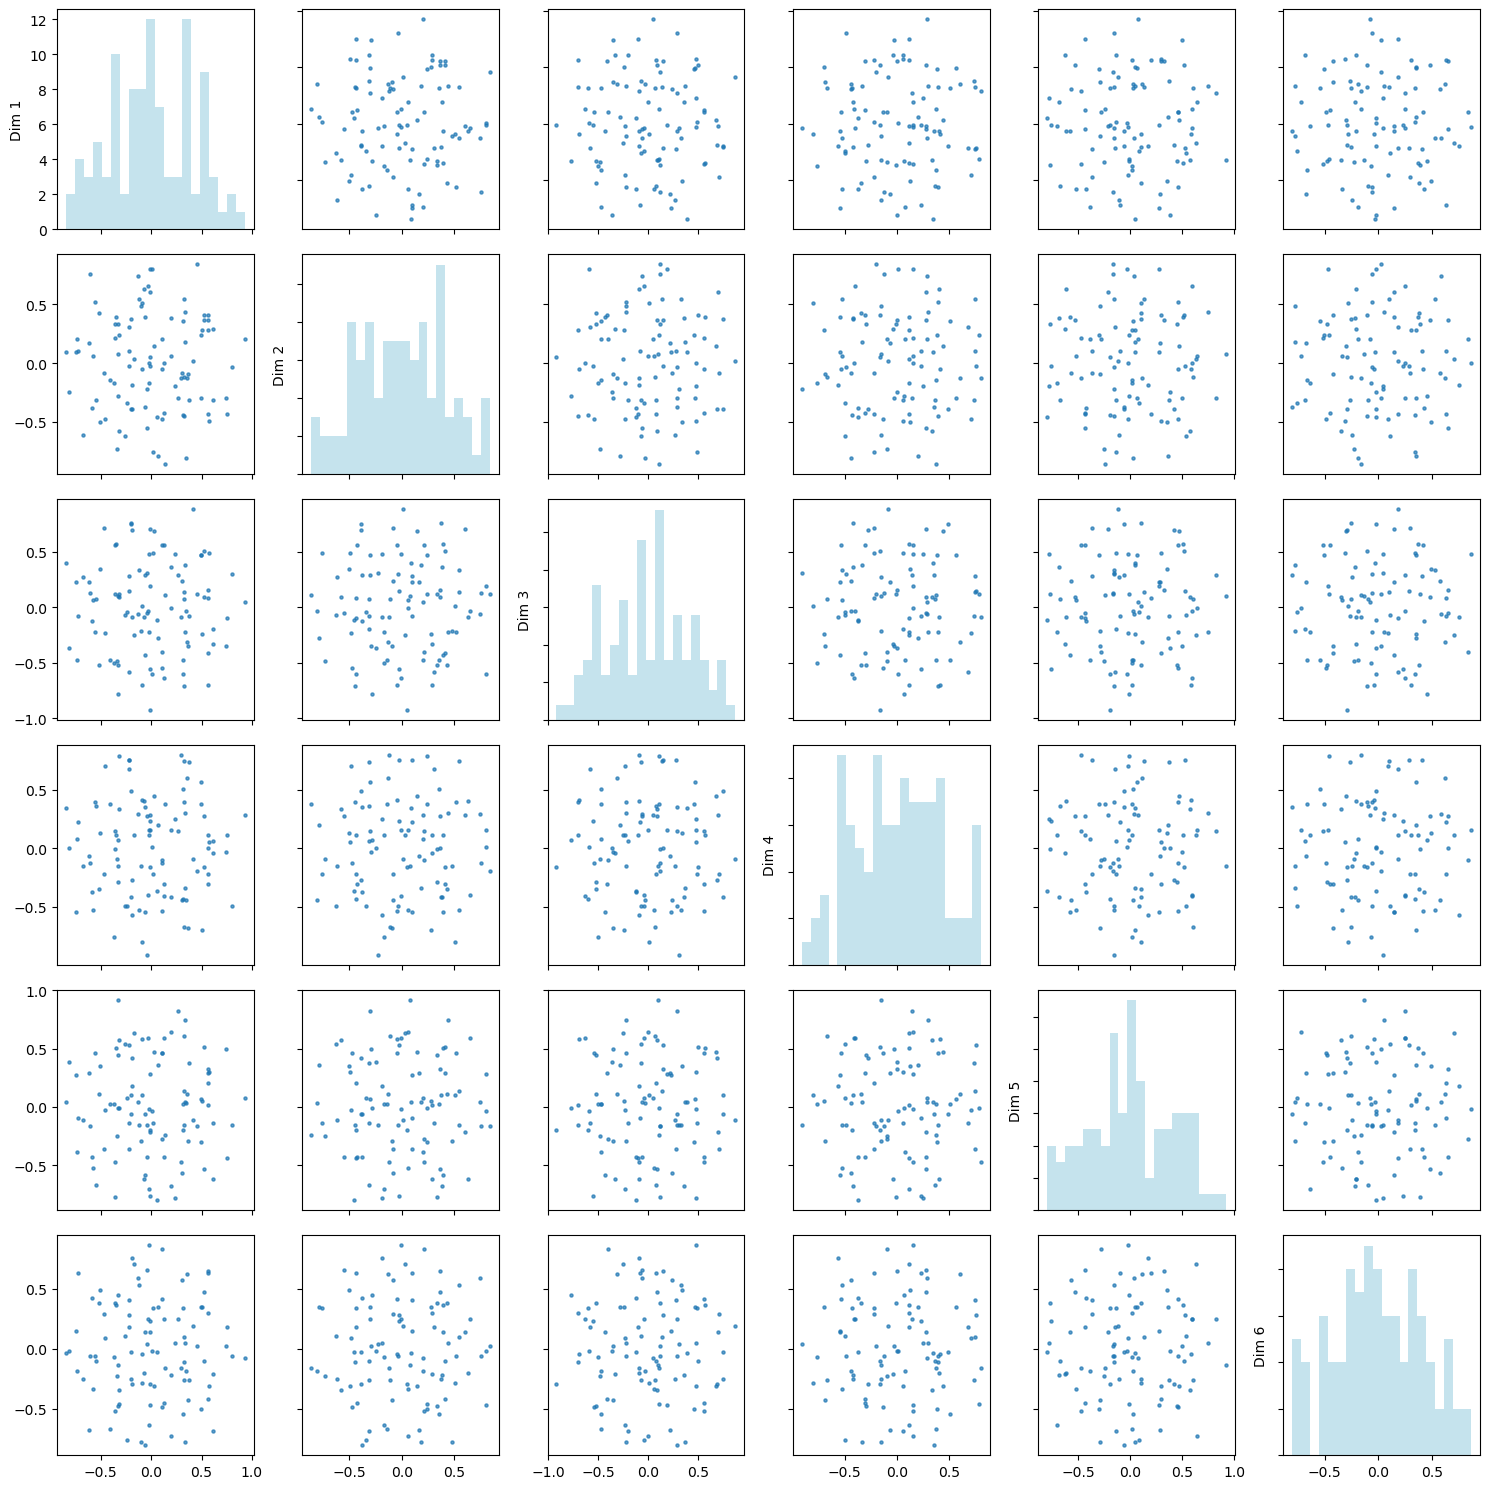

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_pairwise_scatter(points):
    """Create a grid of 2D scatter plots for each pair of axes."""
    num_dims = points.shape[1]  # 7 dimensions for S^6 points
    fig, axes = plt.subplots(num_dims, num_dims, figsize=(15, 15))

    # Iterate over each pair of dimensions
    for i, j in itertools.product(range(num_dims), range(num_dims)):
        ax = axes[i, j]
        if i == j:
            # Diagonal plots: Show a histogram of the values in this dimension
            ax.hist(points[:, i], bins=20, color='lightblue', alpha=0.7)
            ax.set_ylabel(f'Dim {i+1}')
        else:
            # Off-diagonal plots: Show scatter plots for pairs of dimensions
            ax.scatter(points[:, j], points[:, i], s=5, alpha=0.7)
        
        # Remove tick labels for clarity
        if i < num_dims - 1:
            ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()

# Plot the pairwise scatter plots for the optimized points
plot_pairwise_scatter(optimized_points)
